In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import researchpy as rp
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scikit_posthocs as sp

In [2]:
iris = pd.read_excel("/SBA/iris.xlsx",
                     sheet_name = 0,
                     header     = 0)

## 분산분석(ANOVA : Analysis of Variance)
- 독립적인 k개 집단의 양적 자료에 차이가 있는지를 분석하는 방법

In [7]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [8]:
# iris 데이터 설명
# sepal_length : 꽃받침의 길이(cm)
# sepal_width  : 꽃받침의 너비(cm)
# petal_length : 꽃잎의 길이(cm)
# petal_width  : 꽃잎의 너비(cm)
# species      : 꽃의 종류(setosa, versicolor, virginica)

- - -

In [9]:
# 귀무가설 : iris 품종에 따라 꽃잎의 길이에 차이가 없다.
# 대립가설 : iris 품종에 따라 꽃잎의 길이에 차이가 있다.

In [11]:
# 꽃잎의 길이
rp.summary_cont(iris.petal_length)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,petal_length,150.0,3.758,1.7653,0.1441,3.4732,4.0428


In [13]:
# 3 품종 꽃잎의 길이 : petal_length
rp.summary_cont(iris.petal_length.groupby(iris.species))

,N,Mean,SD,SE,95% Conf.,Interval
species,,,,,,
setosa,50,1.462,0.1737,0.0246,1.4126,1.5114
versicolor,50,4.260,0.4699,0.0665,4.1265,4.3935
virginica,50,5.552,0.5519,0.0780,5.3952,5.7088


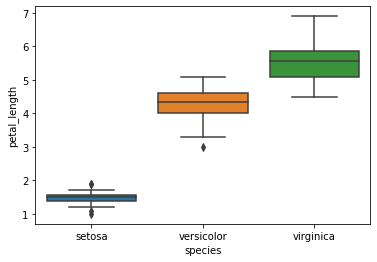

In [14]:
# 품종별 꽃잎의 길이에 대한 상자그림
sns.boxplot(x = "species", y = "petal_length", data = iris)
plt.show()

In [15]:
# 정규성을 만족한다고 할 때 등분산 검정을 한다.
# 귀무가설 : 등분산이다.
# 대립가설 : 이분산이다.

# stats.levene()
# stats.bartlett()

In [16]:
stats.levene(iris.loc[iris.species == "setosa",     "petal_length"],
             iris.loc[iris.species == "versicolor", "petal_length"],
             iris.loc[iris.species == "virginica",  "petal_length"])

LeveneResult(statistic=19.480338801923573, pvalue=3.1287566394085344e-08)

In [17]:
# 결론
# F = 검정통계량 = 19.480
# 유의확률(p-value) = 0.000

# 유의확률이 0.000 이므로 유의수준 0,05에서 이분산이다.

In [20]:
# 이분산이 가정된 분산분석
# pingouin -> pg
# pg.welch_anova(dv = "양적 자료", between = "집단(질적 자료)", data = )

# 참고
# dv : dependent variable = 종속 변수 = 반응 변수 = Label : 양적 자료
# between : independent variable = 독립 변수 = 설명 변수 = Feature : 질적 자료

pg.welch_anova(dv = "petal_length", between = "species", data = iris)

,Source,ddof1,ddof2,F,p-unc,np2
0,species,2,78.072955,1828.091945,2.693327e-66,0.941372


In [21]:
# ddof1 : 자유도(k-1)       = 2
# ddof2 : 자유도(n-k)       = 78.073
# F     : 검정통계량        = 1828.092
# p-unc : 유의확률(p-value) = 0.000

In [22]:
# 결론
# 유의확률이 0.000 이므로 유의수준 0.05 에서
# 품종에 따라 꽃잎의 길이에 통계적으로 유의한 차이가 있는 것으로 나타났다.

- - - 

In [23]:
# 등분산이 가정된 분산분석
# stats.f_oneway(집단1 양적 자료, 집단2 양적 자료, 집단3 양적 자료)

# oneway : 일원배치(하나의 질적 자료를 배치)
stats.f_oneway(iris.loc[iris.species == "setosa", "petal_length"],
               iris.loc[iris.species == "versicolor", "petal_length"],
               iris.loc[iris.species == "virginica", "petal_length"])

F_onewayResult(statistic=1180.161182252981, pvalue=2.8567766109615584e-91)

In [25]:
# 결론
# 유의확률이 0.000 이므로 유의수준 0.05에서
# 품종에 따라 꽃잎의 길이에 통계적으로 유의한 차이가 있는 것으로 나타났다.

- - - 

In [29]:
# 회귀분석 방법을 이용한 분산분석
# result = ols("양적 자료 ~ 질적 자료", data = ).fit()
# sm.stats.anova_lm(result, type = 2)

iris_result = ols("petal_length ~ species", data = iris).fit()
sm.stats.anova_lm(iris_result, type = 2)

,df,sum_sq,mean_sq,F,PR(>F)
species,2.0,437.1028,218.551400,1180.161182,2.856777e-91
Residual,147.0,27.2226,0.185188,NaN,NaN


- - -

#### 2. 크루스칼-왈리스 순위 합 검정(Kruskal-Wallis rank sum test)
- k 집단 중 하나라도 정규성 가정이 깨질 때 사용함

In [31]:
# stats.kruskal(집단1 양적 자료, 집단2 양적자료, 집단3 양적자료)
stats.kruskal(iris.loc[iris.species == "setosa", "petal_length"],
              iris.loc[iris.species == "versicolor", "petal_length"],
              iris.loc[iris.species == "virginica", "petal_length"])

KruskalResult(statistic=130.41104857977163, pvalue=4.803973591157605e-29)

In [32]:
# 결론

# Chi-square        : 검정통계량 = 130.411
# 유의확률(p-value) : 0.000

# 유의확률이 0.000 이므로 유의수준 0.05 에서
# 품종에 따라 꽃잎의 길이에 통계적으로 유의한 차이가 있는 것으로 나타났다.

### 실행 단계

In [33]:
# 1단계 : 정규성 검정(shapiro, anderson)
# 귀무가설 : 정규분포를 따른다.
# 대립가설 : 정규분포를 따르지 않는다.

In [37]:
setosa_normality = stats.shapiro(iris.loc[iris.species == "setosa", "petal_length"])
versicolor_normality = stats.shapiro(iris.loc[iris.species == "versicolor", "petal_length"])
virginica_normality = stats.shapiro(iris.loc[iris.species == "virginica", "petal_length"])

print("Setosa : ", setosa_normality)
print("Versicolor : ", versicolor_normality)
print("Virginica : ", virginica_normality)

Setosa :  ShapiroResult(statistic=0.9549766182899475, pvalue=0.05481043830513954)
Versicolor :  ShapiroResult(statistic=0.9660047888755798, pvalue=0.1584833413362503)
Virginica :  ShapiroResult(statistic=0.9621862769126892, pvalue=0.10977369546890259)


In [38]:
# 결론

# Setosa     : 유의확률 0.055 > 0.05 = 정규성 가정 만족
# Versicolor : 유의확률 0.158 > 0.05 = 정규성 가정 만족
# Virginica  : 유의확률 0.110 > 0.05 = 정규성 가정 만족

In [39]:
# 등분산 검정
# 귀무가설 : 등분산이다.
# 대립가설 : 이분산이다.

stats.levene(iris.loc[iris.species == "setosa",     "petal_length"],
             iris.loc[iris.species == "versicolor", "petal_length"],
             iris.loc[iris.species == "virginica",  "petal_length"])

LeveneResult(statistic=19.480338801923573, pvalue=3.1287566394085344e-08)

In [40]:
# 결론
# 유의확률이 0.000 이므로 유의수준 0.05 에서 이분산이다.

In [41]:
# 3단계 : 이분산이 가정된 분산분석
pg.welch_anova(dv = "petal_length", between = "species", data = iris)

,Source,ddof1,ddof2,F,p-unc,np2
0,species,2,78.072955,1828.091945,2.693327e-66,0.941372


In [42]:
# 결론
# 유의확률 0.000 이므로 유의수준 0.05에서
# 품종에 따라 꽃잎의 길이에 통계적으로 유의한 차이가 있는 것으로 나타났다.

- - -

In [43]:
# 문제1
# 귀무가설 : 품종에 따라 꽃받침의 길이에 차이가 없다.
# 대립가설 : 품종에 따라 꽃받침의 길이에 차이가 있다.

setosa_normality = stats.shapiro(iris.loc[iris.species == "setosa", "sepal_length"])
versicolor_normality = stats.shapiro(iris.loc[iris.species == "versicolor", "sepal_length"])
virginica_normality = stats.shapiro(iris.loc[iris.species == "virginica", "sepal_length"])

print("Setosa : ", setosa_normality)
print("Versicolor : ", versicolor_normality)
print("Virginica : ", virginica_normality)

Setosa :  ShapiroResult(statistic=0.9776989221572876, pvalue=0.4595281183719635)
Versicolor :  ShapiroResult(statistic=0.9778355956077576, pvalue=0.46473264694213867)
Virginica :  ShapiroResult(statistic=0.9711798429489136, pvalue=0.25832483172416687)


In [44]:
# 결론

# Setosa     : 유의확률 0.46 > 0.05 = 정규성 가정 만족
# Versicolor : 유의확률 0.46 > 0.05 = 정규성 가정 만족
# Virginica  : 유의확률 0.26 > 0.05 = 정규성 가정 만족

In [45]:
# 등분산 검정
# 귀무가설 : 등분산이다.
# 대립가설 : 이분산이다.

stats.levene(iris.loc[iris.species == "setosa",     "sepal_length"],
             iris.loc[iris.species == "versicolor", "sepal_length"],
             iris.loc[iris.species == "virginica",  "sepal_length"])

LeveneResult(statistic=6.35272002048269, pvalue=0.0022585277836218586)

In [46]:
# 결론
# 유의확률이 0.002 이므로 유의수준 0.05 에서 이분산이다.

In [47]:
# 3단계 : 이분산이 가정된 분산분석
pg.welch_anova(dv = "sepal_length", between = "species", data = iris)

,Source,ddof1,ddof2,F,p-unc,np2
0,species,2,92.211145,138.908285,1.505059e-28,0.618706


In [48]:
# 결론
# 유의확률 0.000 이므로 유의수준 0.05에서
# 품종에 따라 꽃받침의 길이에 통계적으로 유의한 차이가 있는 것으로 나타났다.

- -- -

#### 다중비교(Multiple Comparisons) = 사후 분석(Post-Hoc)

In [50]:
# (1) 정규성 가정이 만족됐을 때
# mc = MultiComparison(data = 양적 자료, groups = 질적 자료)
# print(mc.tukeyhsd())

iris_mc = MultiComparison(iris.petal_length, iris.species)
print(iris_mc.tukeyhsd())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor    2.798 0.001 2.5942 3.0018   True
    setosa  virginica     4.09 0.001 3.8862 4.2938   True
versicolor  virginica    1.292 0.001 1.0882 1.4958   True
---------------------------------------------------------


In [51]:
# (2) 정규성 가정이 깨졌을 때
# 패키지 : scikit_posthocs
# scikit_posthocs -> sp
# sp.posthoc_conover(data, 
#                    val_col = "양적 자료", group_col = "질적 자료",
#                    p_adjust = "holm")

# val_col   : dependent variable   = 종속 변수 = 검정 변수  = 양적 자료
# group_col : independent variable = 독립 변수 = 그룹(집단) = 질적 자료
# p_adjust  : 다중비교(사후분석)의 방법들
# "holm"    : Bonferroni 방법

In [56]:
sp.posthoc_conover(iris,
                   val_col   = "petal_length",
                   group_col = "species",
                   p_adjust  = "holm")

,setosa,versicolor,virginica
setosa,1.000000e+00,6.147801e-35,7.780252e-68
versicolor,6.147801e-35,1.000000e+00,4.856904e-33
virginica,7.780252e-68,4.856904e-33,1.000000e+00


In [57]:
# 결론

# Setosa VS Versicolor    : 유의확률(0.000) : 두 집단 간에 통계적으로 유의한 차이 있음
# Setosa VS Virginica     : 유의확률(0.000) : 두 집단 간에 통계적으로 유의한 차이 있음
# Versicolor VS Virginica : 유의확률(0.000) : 두 집단 간에 통계적으로 유의한 차이 있음